In [1]:
# -*- coding: utf-8 -*-
import argparse
import logging
import os

import numpy as np
import scipy.io as sio
from matplotlib import pyplot as plt

import utils
from model import dsfa

In [2]:
net_shape = [128, 128, 6] 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.basicConfig(format='%(asctime)-15s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %H:%M:%S', level=logging.INFO)

In [3]:
def parser():
    parser = argparse.ArgumentParser(description='')

    parser.add_argument('-e','--epoch',help='epoches',default=2000, type=int)
    parser.add_argument('-l','--lr',help='learning rate',default=5*1e-5, type=float)
    parser.add_argument('-r','--reg',help='regularization parameter',default=1e-4, type=float)
    parser.add_argument('-t','--trn',help='number of training samples',default=2000, type=int)
    parser.add_argument('-g','--gpu', help='GPU ID', default='0')
    parser.add_argument('--area',help='datasets', default='river')
    args = parser.parse_args()

    return args

In [4]:
class config():
    def __init__(self):
        self.epoch = 2000
        self.lr = 1e-4
        self.reg = 1e-4
        self.trn = 3000
        self.gpu = '0'
        self.area = 'river'

In [5]:
def main(img1, img2, chg_map, args=None):

    img_shape = np.shape(img1)

    im1 = np.reshape(img1, newshape=[-1,img_shape[-1]])
    im2 = np.reshape(img2, newshape=[-1,img_shape[-1]])

    im1 = utils.normlize(im1)
    im2 = utils.normlize(im2)

    chg_ref = np.reshape(chg_map, newshape=[-1])

    imm = None
    all_magnitude = None
    differ = np.zeros(shape=[np.shape(chg_ref)[0],net_shape[-1]])

    # load cva pre-detection result
    ind = sio.loadmat(args.area+'/cva_ref.mat')
    cva_ind = ind['cva_ref']
    cva_ind = np.reshape(cva_ind, newshape=[-1])

    i1, i2 = utils.getTrainSamples(cva_ind, im1, im2, args.trn)

    loss_log, vpro, fcx, fcy, bval = dsfa(
        xtrain=i1, ytrain=i2, xtest=im1, ytest=im2, net_shape=net_shape, args=args)

    imm, magnitude, differ_map = utils.linear_sfa(fcx, fcy, vpro, shape=img_shape)

    magnitude = np.reshape(magnitude, img_shape[0:-1])
    differ = differ_map

    change_map = np.reshape(utils.kmeans(np.reshape(magnitude, [-1])), img_shape[0:-1])

    # magnitude
    acc_un, acc_chg, acc_all2, acc_tp = utils.metric(1-change_map, chg_map)
    acc_un, acc_chg, acc_all3, acc_tp = utils.metric(change_map, chg_map)
    plt.imsave('results.png',change_map, cmap='gray')
    plt.imshow(change_map)
    plt.show()

    return None

03/28/2020 23:39:51 WARNING: From C:\Users\rulix\Desktop\cd\demo\model.py:14: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



03/28/2020 23:39:51 WARNING: From C:\Users\rulix\Desktop\cd\demo\model.py:18: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



03/28/2020 23:39:51 WARNING: From C:\Users\rulix\Desktop\cd\demo\model.py:22: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.



03/28/2020 23:39:51 WARNING: From C:\Users\rulix\Desktop\cd\demo\model.py:75: The name tf.self_adjoint_eig is deprecated. Please use tf.linalg.eigh instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


03/28/2020 23:39:51 WARNING: From C:\Users\rulix\Desktop\cd\demo\model.py:76: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


03/28/2020 23:39:51 WARNING: From C:\Users\rulix\Desktop\cd\demo\model.py:79: The name tf.diag is deprecated. Please use tf.linalg.tensor_diag instead.



03/28/2020 23:39:51 WARNING: From C:\Users\rulix\Desktop\cd\demo\model.py:88: The name tf.train.GradientDescentOptimizer is deprecated. Please use tf.compat.v1.train.GradientDescentOptimizer instead.

03/28/2020 23:39:53 INFO: The    0-th epochs, loss is 3.8275 
03/28/2020 23:39:54 INFO: The  100-th epochs, loss is 0.7504 
03/28/2020 23:39:54 INFO: The  200-th epochs, loss is 0.5266 
03/28/2020 23:39:55 INFO: The  300-th epochs, loss is 0.4261 
03/28/2020 23:39:56 INFO: The  400-th epochs, loss is 0.3633 
03/28/2020 23:39:57 INFO: The  500-th epochs, loss is 0.3167 
03/28/2020 23:39:58 INFO: The  600-th epochs, loss is 0.2783 
03/28/2020 23:39:59 INFO: The  700-th epochs, loss is 0.2448 
03/28/2020 23:40:00 INFO: The  800-th epochs, loss is 0.2152 
03/28/2020 23:40:01 INFO: The  900-th epochs, loss is 0.1892 
03/28/2020 23:40:01 INFO: The 1000-th epochs, loss is 0.1673 
03/28/2020 23:40:02 INFO: The 1100-th epochs, loss is 0.1493 
03/28/2020 23:40:03 INFO: The 1200-th epochs, loss is 0



Accuracy of Unchanged Regions is: 0.9798
Accuracy of Changed Regions is:   0.6144
The True Positive ratio is:       0.7437
Accuracy of all testing sets is : 0.9481

Accuracy of Unchanged Regions is: 0.0202
Accuracy of Changed Regions is:   0.3856
The True Positive ratio is:       0.0361
Accuracy of all testing sets is : 0.0519


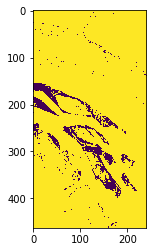

In [6]:
if __name__ == '__main__':
    args = config()
    img1, img2, chg_map = utils.data_loader(area=args.area)
    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
    main(img1, img2, chg_map, args=args)